In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
crashes = pd.read_csv('dataset/crashes_cleaned.csv')

In [3]:
len(crashes)

841633

In [4]:
crashes.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841633 entries, 0 to 841632
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CRASH_RECORD_ID                   841633 non-null  object 
 1   CRASH_DATE                        841633 non-null  object 
 2   POSTED_SPEED_LIMIT                841633 non-null  int64  
 3   WEATHER_SEVERITY                  841633 non-null  int64  
 4   LIGHTING_SEVERITY                 841633 non-null  int64  
 5   FIRST_CRASH_TYPE                  841633 non-null  object 
 6   TRAFFICWAY_TYPE                   841633 non-null  object 
 7   ROADWAY_SEVERITY                  841633 non-null  int64  
 8   CRASH_TYPE                        841633 non-null  object 
 9   DAMAGE_SEVERITY                   841633 non-null  int64  
 10  PRIM_CONTRIBUTORY_CAUSE           841633 non-null  object 
 11  SEC_CONTRIBUTORY_CAUSE            841633 non-null  o

In [5]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841633 entries, 0 to 841632
Data columns (total 64 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CRASH_RECORD_ID                   841633 non-null  object 
 1   CRASH_DATE                        841633 non-null  object 
 2   POSTED_SPEED_LIMIT                841633 non-null  int64  
 3   WEATHER_SEVERITY                  841633 non-null  int64  
 4   LIGHTING_SEVERITY                 841633 non-null  int64  
 5   FIRST_CRASH_TYPE                  841633 non-null  object 
 6   TRAFFICWAY_TYPE                   841633 non-null  object 
 7   ROADWAY_SEVERITY                  841633 non-null  int64  
 8   CRASH_TYPE                        841633 non-null  object 
 9   DAMAGE_SEVERITY                   841633 non-null  int64  
 10  PRIM_CONTRIBUTORY_CAUSE           841633 non-null  object 
 11  SEC_CONTRIBUTORY_CAUSE            841633 non-null  o

In [6]:
crashes.columns.sort_values()

Index(['AGE', 'BEAT_OF_OCCURRENCE', 'CATEGORY_Motorcycle',
       'CATEGORY_Off-Road/Specialized', 'CATEGORY_Passenger Vehicle',
       'CATEGORY_Public Transport', 'CATEGORY_Truck/Commercial', 'CRASH_DATE',
       'CRASH_DAY', 'CRASH_DAY_OF_WEEK', 'CRASH_HOUR', 'CRASH_MONTH',
       'CRASH_RECORD_ID', 'CRASH_TYPE', 'CRASH_TYPE_b', 'CRASH_YEAR',
       'DAMAGE_CATEGORY_HIGH', 'DAMAGE_CATEGORY_LOW', 'DAMAGE_CATEGORY_MEDIUM',
       'DAMAGE_SEVERITY', 'FIRST_CRASH_TYPE', 'GENDER_FEMALE', 'GENDER_MALE',
       'GENDER_UNKNOWN', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
       'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
       'INJURIES_TOTAL', 'LATITUDE', 'LIGHTING_CATEGORY_DAYLIGHT',
       'LIGHTING_CATEGORY_NIGHT', 'LIGHTING_CATEGORY_UNKNOWN',
       'LIGHTING_SEVERITY', 'LONGITUDE', 'MOST_SEVERE_INJURY', 'NUM_UNITS',
       'POSTED_SPEED_LIMIT', 'PRIM_CONTRIBUTORY_CAUSE', 'ROADWAY_SEVERITY',
       'ROADWAY_SURFACE_CATEGORY_DRY', 'ROADWAY_SURFACE_CATEGORY_ICE',


# DA METTERE IN UNDERSTANDING/DISTRIBUTION

In [7]:
crashes["DAMAGE_COST"] = crashes["DAMAGE_SEVERITY"].map({0: 500, 1: 1000, 2: 1500})
crashes["DAMAGE_COST"].value_counts()

DAMAGE_COST
1500    537246
1000    211258
500      93129
Name: count, dtype: int64

In [8]:
#category vehicle type number of fatalities
crashes.groupby(['CATEGORY_Off-Road/Specialized', 'INJURIES_FATAL']).size()


CATEGORY_Off-Road/Specialized  INJURIES_FATAL
0.0                            0.0               745583
                               1.0                  824
                               2.0                   61
                               3.0                    8
                               4.0                    1
1.0                            0.0                  247
2.0                            0.0                    3
dtype: int64

In [9]:

#category vehicle type number of fatalities
crashes.groupby(['CATEGORY_Passenger Vehicle', 'INJURIES_FATAL']).size()

CATEGORY_Passenger Vehicle  INJURIES_FATAL
0.0                         0.0                29184
                            1.0                   62
                            2.0                    2
1.0                         0.0               262968
                            1.0                  559
                            2.0                   28
                            3.0                    5
                            4.0                    1
2.0                         0.0               430544
                            1.0                  159
                            2.0                   23
                            3.0                    2
3.0                         0.0                19825
                            1.0                   25
                            2.0                    4
4.0                         0.0                 2846
                            1.0                   16
                            2.0                    1
   

Probably are different type of cars but as long as it is > 0 then it is that category

In [10]:
crashes['Fatality_Vehicle_passenger'] = 0
crashes.loc[(crashes['CATEGORY_Passenger Vehicle'] > 0), 'Fatality_Vehicle_passenger'] = crashes['INJURIES_FATAL']

In [11]:
crashes['Fatality_Vehicle_passenger'].value_counts()

Fatality_Vehicle_passenger
0    840803
1       762
2        59
3         8
4         1
Name: count, dtype: int64

In [12]:
crashes['Fatality_Off-Road/Specialized'] = 0
crashes.loc[(crashes['CATEGORY_Off-Road/Specialized'] > 0), 'Fatality_Off-Road/Specialized'] = crashes['INJURIES_FATAL']
crashes['Fatality_Off-Road/Specialized'].value_counts()

Fatality_Off-Road/Specialized
0    841633
Name: count, dtype: int64

In [13]:
crashes['Fatality_Motorcycle'] = 0
crashes.loc[(crashes['CATEGORY_Motorcycle'] > 0), 'Fatality_Motorcycle'] = crashes['INJURIES_FATAL']
crashes['Fatality_Motorcycle'].value_counts()

Fatality_Motorcycle
0    841561
1        70
2         2
Name: count, dtype: int64

In [14]:
#do the same for CATEGORY_Public Transport
crashes['Fatality_Public Transport'] = 0
crashes.loc[(crashes['CATEGORY_Public Transport'] > 0), 'Fatality_Public Transport'] = crashes['INJURIES_FATAL']
crashes['Fatality_Public Transport'].value_counts()


Fatality_Public Transport
0    841610
1        22
4         1
Name: count, dtype: int64

In [15]:
# CATEGORY_Truck/Commercial
crashes['Fatality_Truck/Commercial'] = 0
crashes.loc[(crashes['CATEGORY_Truck/Commercial'] > 0), 'Fatality_Truck/Commercial'] = crashes['INJURIES_FATAL']
crashes['Fatality_Truck/Commercial'].value_counts()

Fatality_Truck/Commercial
0    841582
1        47
2         4
Name: count, dtype: int64

In [16]:
crashes['INJURIES_FATAL'].value_counts()
#sum Fatality columns
tot = crashes['Fatality_Vehicle_passenger'] + crashes['Fatality_Off-Road/Specialized'] + crashes['Fatality_Motorcycle'] + crashes['Fatality_Public Transport'] + crashes['Fatality_Truck/Commercial']
tot.value_counts()


0    840739
1       749
2       130
3        10
4         4
8         1
Name: count, dtype: int64

In [17]:
crashes['INJURIES_FATAL'].value_counts()

INJURIES_FATAL
0.0    840673
1.0       886
2.0        65
3.0         8
4.0         1
Name: count, dtype: int64

---

In [24]:
import pandas as pd

# Ensure proper data types
crashes["CRASH_YEAR"] = crashes["CRASH_YEAR"].astype(int)
crashes["CRASH_MONTH"] = crashes["CRASH_MONTH"].astype(int)
crashes["BEAT_OF_OCCURRENCE"] = crashes["BEAT_OF_OCCURRENCE"].astype(float)
crashes["AGE"] = pd.to_numeric(crashes["AGE"], errors="coerce")

# Identify all categorical columns dynamically (all starting with 'CATEGORY_', 'LIGHTING_CATEGORY_', 'ROADWAY_SURFACE_CATEGORY_', etc.)
categorical_columns = [col for col in crashes.columns if col.startswith(
    ("CATEGORY_", "LIGHTING_CATEGORY_", "ROADWAY_SURFACE_CATEGORY_", "ROAD_DEFECT_CATEGORY_", "DAMAGE_CATEGORY_"))]
crashes[categorical_columns] = crashes[categorical_columns].apply(pd.to_numeric, errors="coerce")

# Feature Engineering: Creating new indicators
crashes["fatality_rate"] = crashes["INJURIES_FATAL"] / (crashes["INJURIES_TOTAL"] + 1)
crashes["severe_injury_rate"] = crashes["INJURIES_INCAPACITATING"] / (crashes["INJURIES_TOTAL"] + 1)
crashes["injury_severity_score"] = (
    (1 * crashes["INJURIES_NON_INCAPACITATING"]) +
    (5 * crashes["INJURIES_INCAPACITATING"]) +
    (10 * crashes["INJURIES_FATAL"])
)
crashes["vehicle_involvement_rate"] = crashes["NUM_UNITS"] / crashes.groupby(["CRASH_YEAR", "CRASH_MONTH", "BEAT_OF_OCCURRENCE"]).transform("count")["CRASH_RECORD_ID"]
crashes["night_crash_rate"] = crashes["LIGHTING_CATEGORY_NIGHT"].astype(int)
crashes["adverse_weather_crash_rate"] = crashes[["WEATHER_CATEGORY_RAIN", "WEATHER_CATEGORY_EXTREME"]].sum(axis=1)
crashes["road_defect_crash_rate"] = crashes[["ROAD_DEFECT_CATEGORY_BAD", "ROAD_DEFECT_CATEGORY_DEFECT", "ROAD_DEFECT_CATEGORY_DEBRIS"]].sum(axis=1)
crashes["speeding_influence"] = (crashes["POSTED_SPEED_LIMIT"] > 30).astype(int)
crashes["weekend_crash_rate"] = (crashes["CRASH_DAY_OF_WEEK"].isin([6, 7])).astype(int)

# Define neo-patented and senior drivers
crashes["neo_patented_drivers"] = (crashes["AGE"] <= 21).astype(int)
crashes["senior_drivers"] = (crashes["AGE"] >= 65).astype(int)

# Exclude -1 values from mean calculations
def exclude_negatives(series):
    return series.loc[series != -1].mean()

# Grouping by year, month, and police department
incident_profile = crashes.groupby(["CRASH_YEAR", "CRASH_MONTH", "BEAT_OF_OCCURRENCE"]).agg(
    avg_age=("AGE", "mean"),
    avg_responsibility_score=("responsibility_score", "mean"),
    avg_weather_severity=("WEATHER_SEVERITY", exclude_negatives),
    avg_roadway_severity=("ROADWAY_SEVERITY", exclude_negatives),
    avg_lighting_severity=("LIGHTING_SEVERITY", exclude_negatives),
    total_crashes=("CRASH_RECORD_ID", "count"),
    fatality_rate=("fatality_rate", "mean"),
    severe_injury_rate=("severe_injury_rate", "mean"),
    avg_crash_severity_score=("crash_severity_score", "mean"),
    injury_severity_score=("injury_severity_score", "sum"),
    vehicle_involvement_rate=("vehicle_involvement_rate", "mean"),
    night_crash_rate=("night_crash_rate", "mean"),
    adverse_weather_crash_rate=("adverse_weather_crash_rate", "mean"),
    road_defect_crash_rate=("road_defect_crash_rate", "mean"),
    speeding_influence=("speeding_influence", "mean"),
    weekend_crash_rate=("weekend_crash_rate", "mean"),
    neo_patented_drivers=("neo_patented_drivers", "sum"),
    senior_drivers=("senior_drivers", "sum"),
    num_towed_units_LB=("TOW", "sum"),
    damage_low=("DAMAGE_CATEGORY_LOW", "sum"),
    damage_medium=("DAMAGE_CATEGORY_MEDIUM", "sum"),
    damage_high=("DAMAGE_CATEGORY_HIGH", "sum"),
    damage_cost_LB=("DAMAGE_COST", "sum"),
    **{f"sum_{col.lower()}": (col, "sum") for col in categorical_columns}
).reset_index()

# Save the result to a CSV file
incident_profile.to_csv("dataset/incident_profile.csv", index=False)

# Display the first few rows
incident_profile.head()


,CRASH_YEAR,CRASH_MONTH,BEAT_OF_OCCURRENCE,avg_age,avg_responsibility_score,avg_weather_severity,avg_roadway_severity,avg_lighting_severity,total_crashes,fatality_rate,severe_injury_rate,avg_crash_severity_score,injury_severity_score,vehicle_involvement_rate,night_crash_rate,adverse_weather_crash_rate,road_defect_crash_rate,speeding_influence,weekend_crash_rate,neo_patented_drivers,senior_drivers,num_towed_units_LB,damage_low,damage_medium,damage_high,damage_cost_LB,sum_lighting_category_daylight,sum_lighting_category_night,sum_lighting_category_unknown,sum_roadway_surface_category_dry,sum_roadway_surface_category_wet,sum_roadway_surface_category_snow,sum_roadway_surface_category_ice,sum_roadway_surface_category_unknown,sum_road_defect_category_no_defects,sum_road_defect_category_bad,sum_road_defect_category_defect,sum_road_defect_category_debris,sum_road_defect_category_unknown,sum_damage_category_high,sum_damage_category_low,sum_damage_category_medium,sum_category_motorcycle,sum_category_off-road/specialized,sum_category_passenger vehicle,sum_category_public transport,sum_category_truck/commercial
0,2017,1,111.0,48.525000,0.545000,0.578947,0.263158,0.550000,20,0.0,0.000000,0.021354,0.0,0.100000,0.500000,0.200000,0.000000,0.050000,0.150000,0,4,0,3,6,11,24000,10,10,0,14,6,0,0,0,19,0,0,0,1,11,3,6,0.0,0.0,28.0,1.0,3.0
1,2017,1,112.0,44.823529,0.488889,0.705882,0.437500,0.647059,18,0.0,0.000000,0.020658,0.0,0.111111,0.388889,0.277778,0.000000,0.000000,0.000000,0,1,0,5,6,7,19000,10,7,1,13,4,0,1,0,16,0,0,0,2,7,5,6,0.0,0.0,30.0,0.0,2.0
2,2017,1,113.0,44.388889,0.505000,0.368421,0.176471,0.315789,20,0.0,0.000000,0.027012,0.0,0.105000,0.250000,0.150000,0.000000,0.050000,0.050000,0,1,0,4,3,13,24500,14,5,1,15,4,0,0,1,17,0,0,0,3,13,4,3,0.0,0.0,37.0,1.0,0.0
3,2017,1,114.0,42.208333,0.501887,0.367347,0.413043,0.566038,53,0.0,0.012579,0.066048,10.0,0.037736,0.452830,0.150943,0.037736,0.207547,0.094340,0,3,4,15,15,23,57000,29,24,0,38,10,1,1,3,44,2,0,0,7,23,15,15,0.0,0.0,80.0,2.0,4.0
4,2017,1,121.0,39.703125,0.450000,0.485714,0.400000,0.555556,36,0.0,0.000000,0.026729,0.0,0.055556,0.416667,0.222222,0.027778,0.083333,0.055556,2,1,0,5,7,24,45500,21,15,0,23,12,0,0,1,29,0,0,1,6,24,5,7,0.0,0.0,57.0,2.0,3.0


In [25]:
incident_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26185 entries, 0 to 26184
Data columns (total 47 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CRASH_YEAR                            26185 non-null  int64  
 1   CRASH_MONTH                           26185 non-null  int64  
 2   BEAT_OF_OCCURRENCE                    26185 non-null  float64
 3   avg_age                               26180 non-null  float64
 4   avg_responsibility_score              26185 non-null  float64
 5   avg_weather_severity                  26185 non-null  float64
 6   avg_roadway_severity                  26179 non-null  float64
 7   avg_lighting_severity                 26185 non-null  float64
 8   total_crashes                         26185 non-null  int64  
 9   fatality_rate                         26185 non-null  float64
 10  severe_injury_rate                    26185 non-null  float64
 11  avg_crash_sever

In [26]:
# percentage of missing values
incident_profile.isnull().mean() * 100



CRASH_YEAR                              0.000000
CRASH_MONTH                             0.000000
BEAT_OF_OCCURRENCE                      0.000000
avg_age                                 0.019095
avg_responsibility_score                0.000000
avg_weather_severity                    0.000000
avg_roadway_severity                    0.022914
avg_lighting_severity                   0.000000
total_crashes                           0.000000
fatality_rate                           0.000000
severe_injury_rate                      0.000000
avg_crash_severity_score                0.000000
injury_severity_score                   0.000000
vehicle_involvement_rate                0.000000
night_crash_rate                        0.000000
adverse_weather_crash_rate              0.000000
road_defect_crash_rate                  0.000000
speeding_influence                      0.000000
weekend_crash_rate                      0.000000
neo_patented_drivers                    0.000000
senior_drivers      

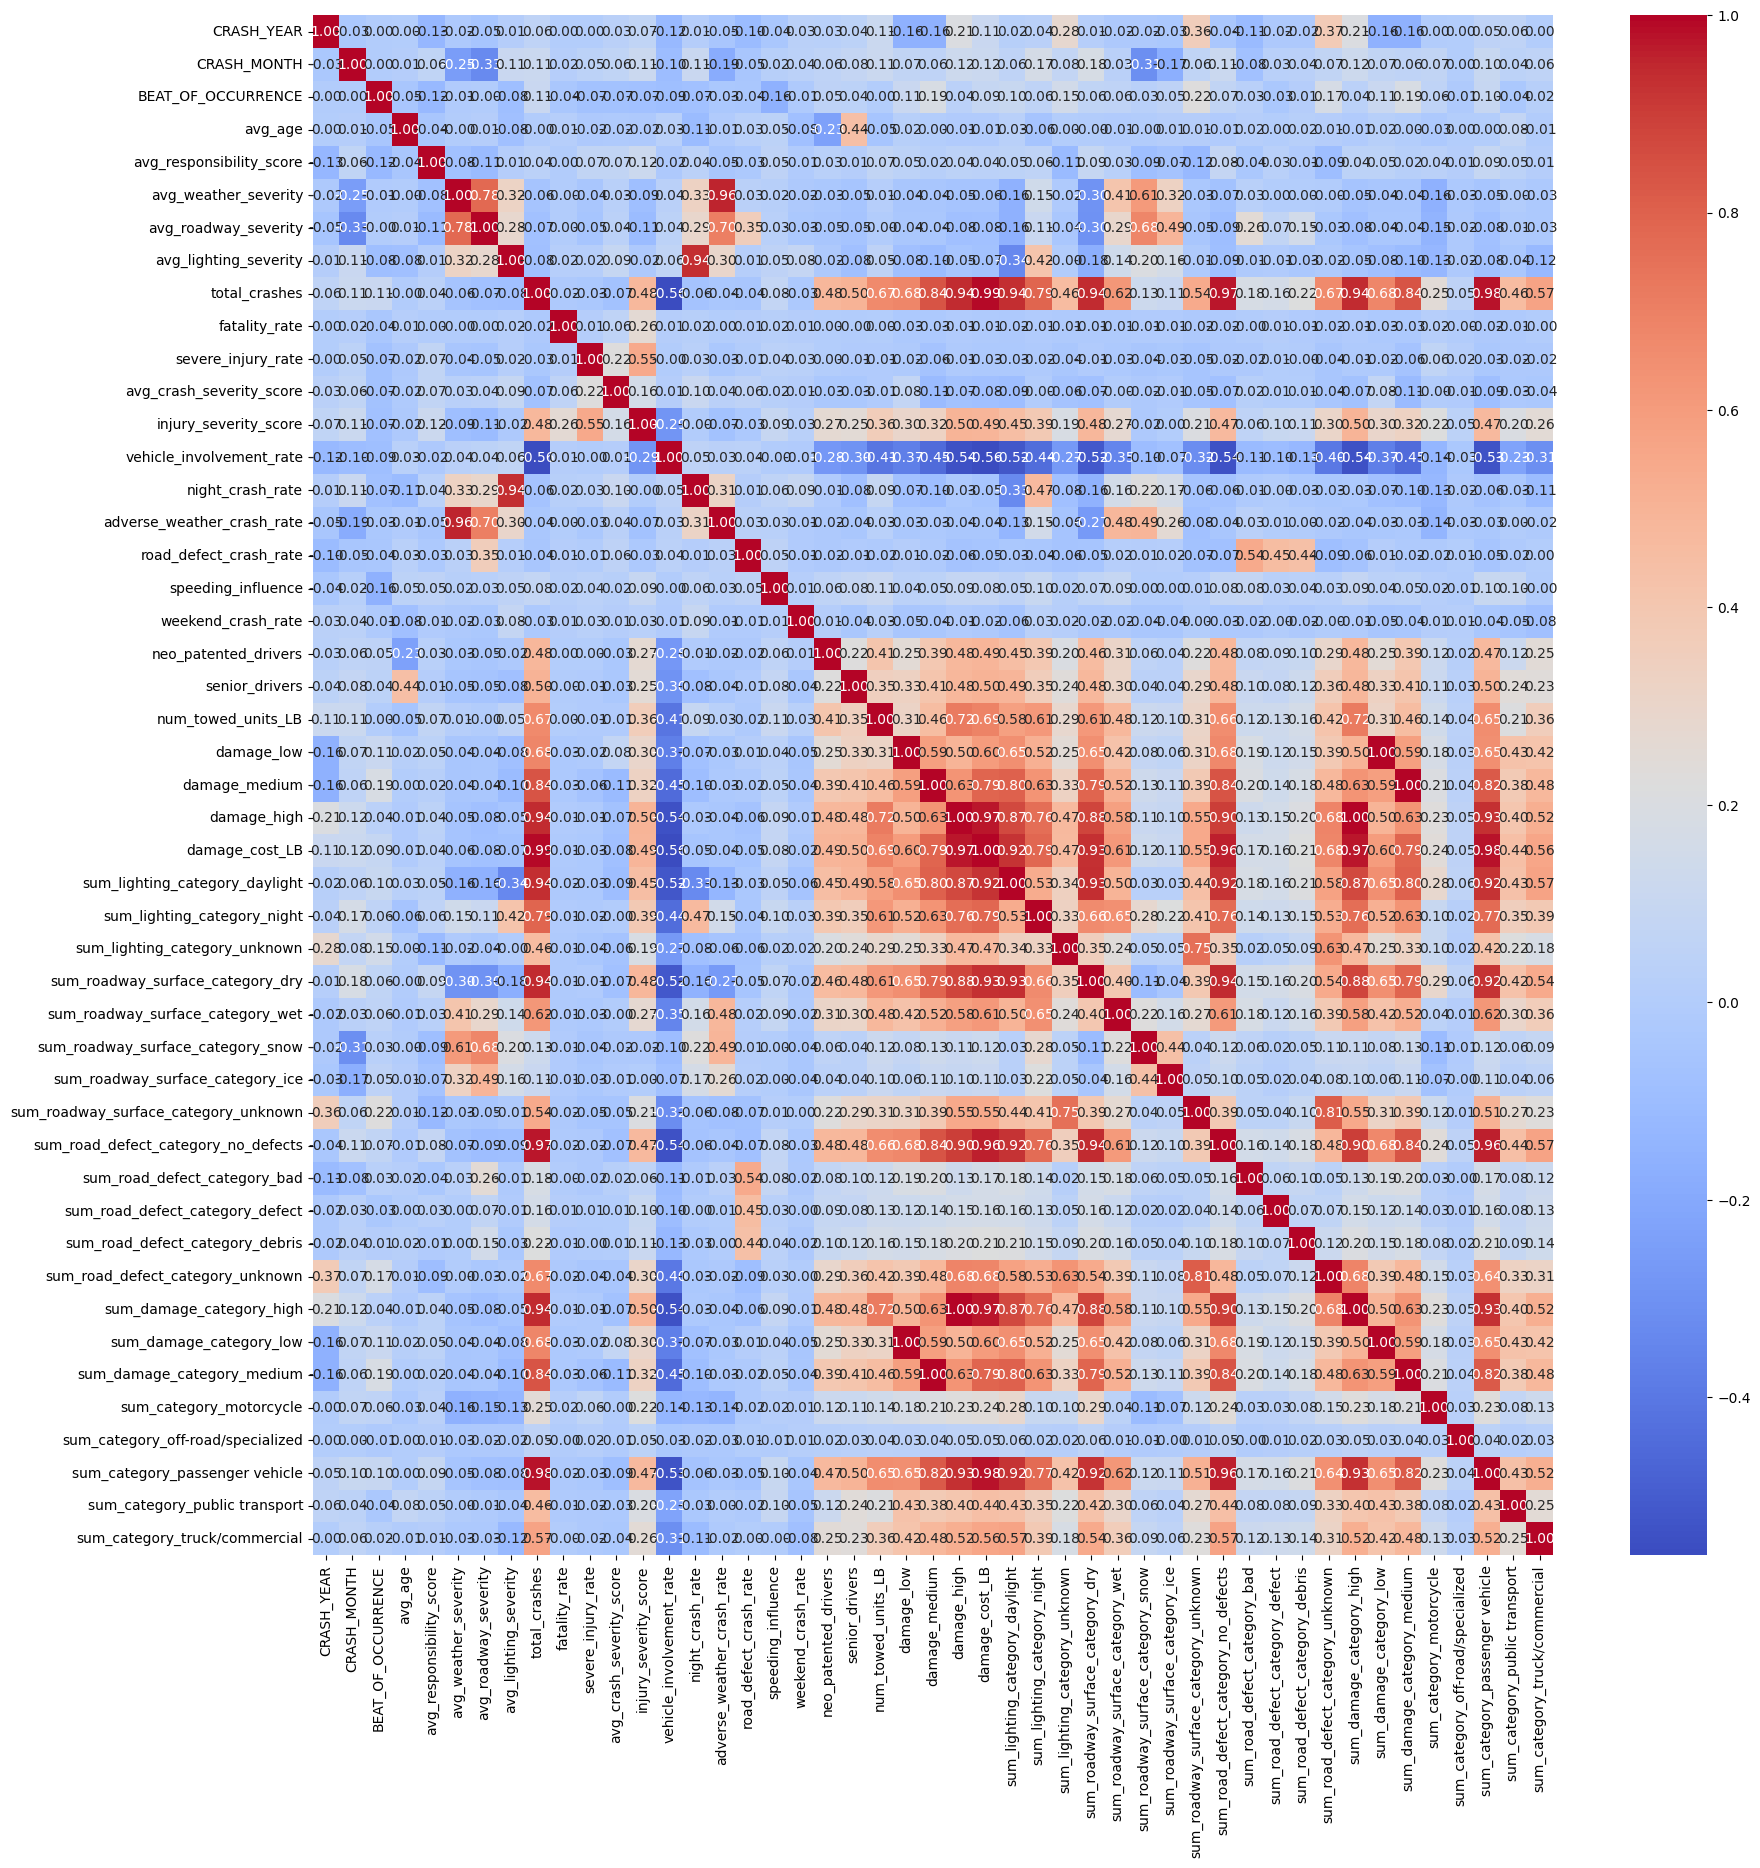

In [27]:
# plot correlation matric for incident_profile
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(incident_profile.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()




---

# first quick correlation analisys

In [28]:
# columns to analize

columns = ['avg_age', 'avg_responsibility_score', 'avg_weather_severity',
           'avg_roadway_severity', 'avg_lighting_severity', 'total_crashes', 'fatality_rate',
           'severe_injury_rate', 'avg_crash_severity_score', 'injury_severity_score', 'vehicle_involvement_rate',
           'night_crash_rate', 'adverse_weather_crash_rate', 'road_defect_crash_rate', 'speeding_influence',
           'weekend_crash_rate', 'neo_patented_drivers', 'senior_drivers', 'num_towed_units_LB', 'damage_low','damage_medium', 
           'damage_high', 'damage_cost_LB']

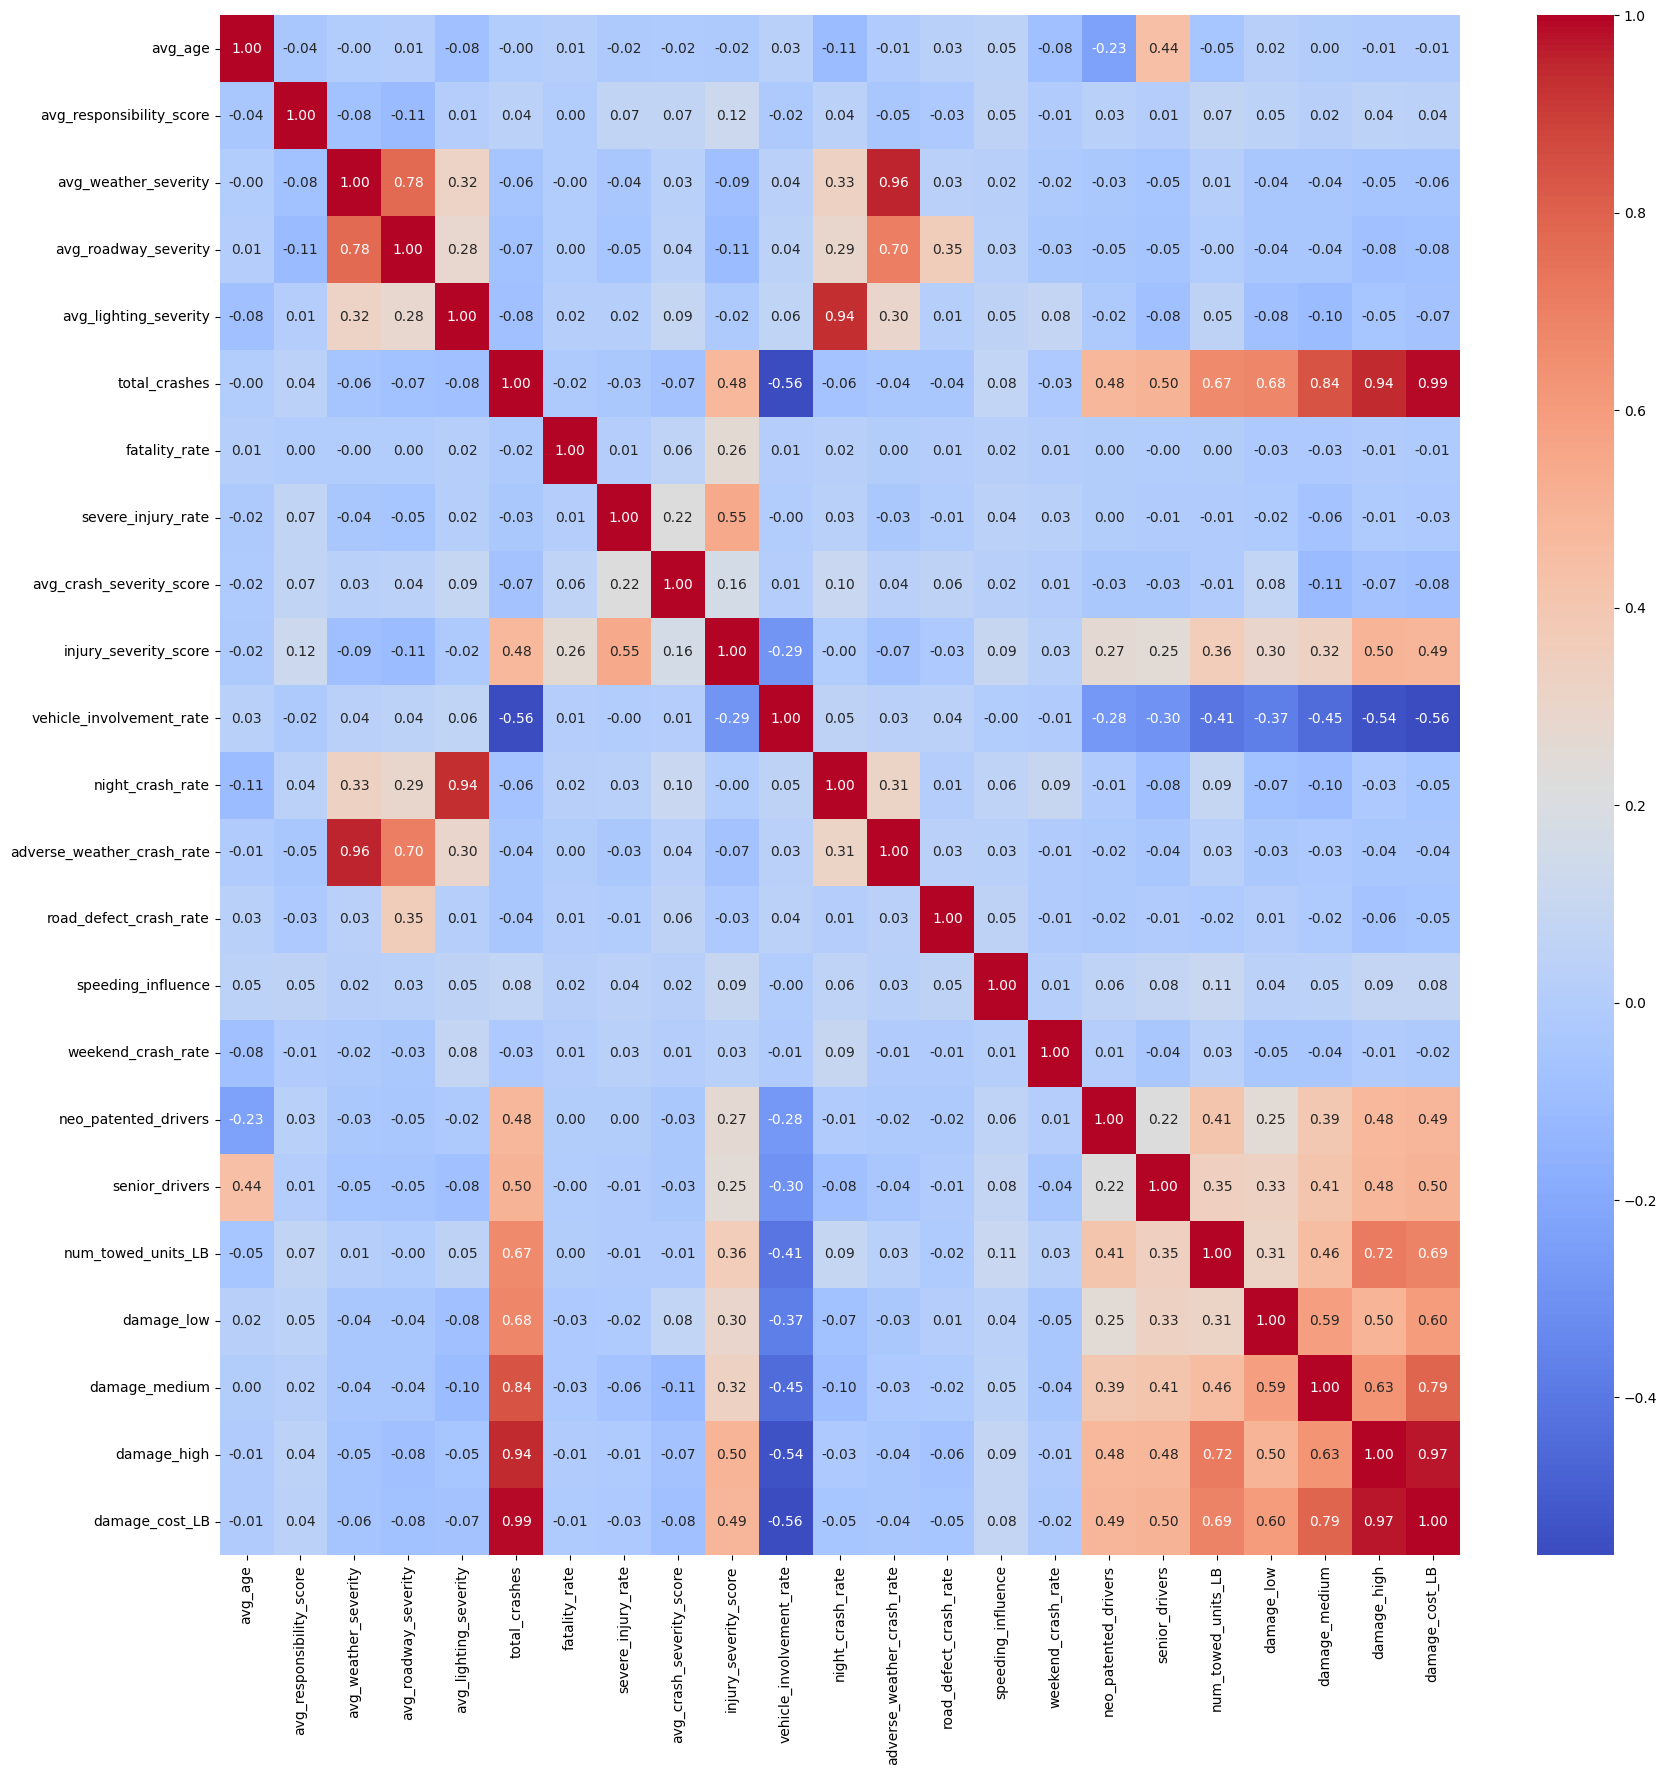

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(incident_profile[columns].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

---

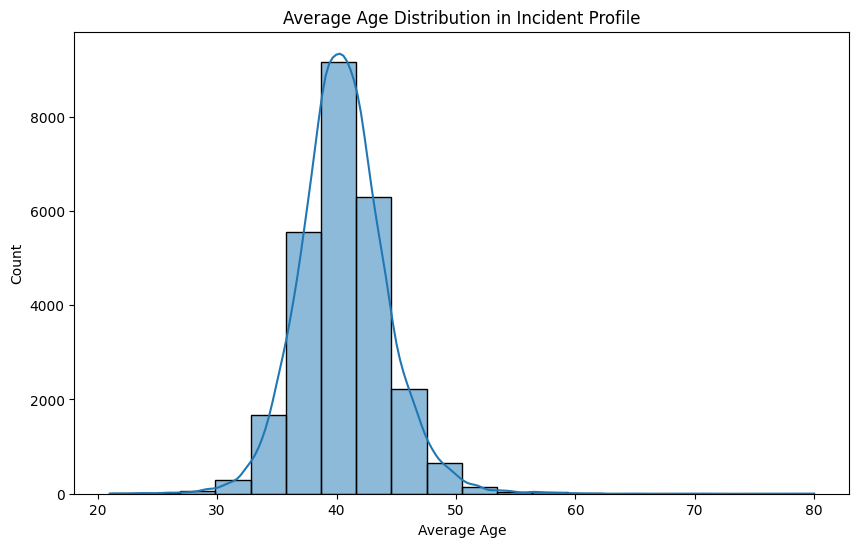

In [31]:
# age distribution for incident profile
plt.figure(figsize=(10, 6))
sns.histplot(incident_profile["avg_age"], bins=20, kde=True)
plt.title("Average Age Distribution in Incident Profile")
plt.xlabel("Average Age")
plt.ylabel("Count")
plt.show()


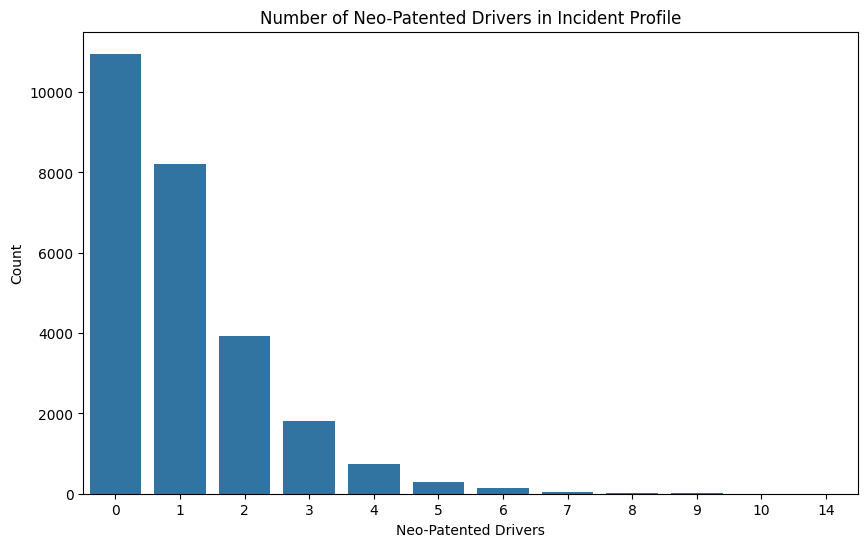

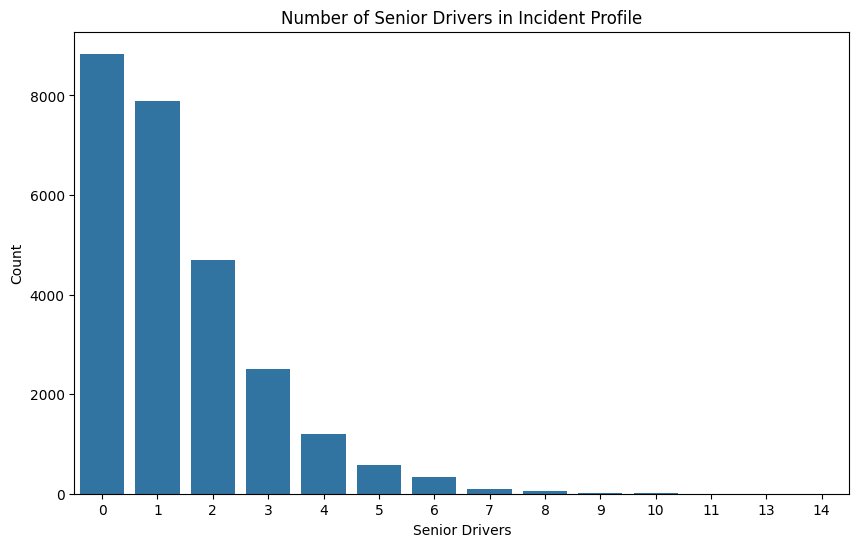

In [32]:
# number of neo-patented drivers and senior drivers
plt.figure(figsize=(10, 6))
sns.countplot(data=incident_profile, x="neo_patented_drivers")
plt.title("Number of Neo-Patented Drivers in Incident Profile")
plt.xlabel("Neo-Patented Drivers")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=incident_profile, x="senior_drivers")
plt.title("Number of Senior Drivers in Incident Profile")
plt.xlabel("Senior Drivers")
plt.ylabel("Count")
plt.show()


Text(0, 0.5, 'Count')

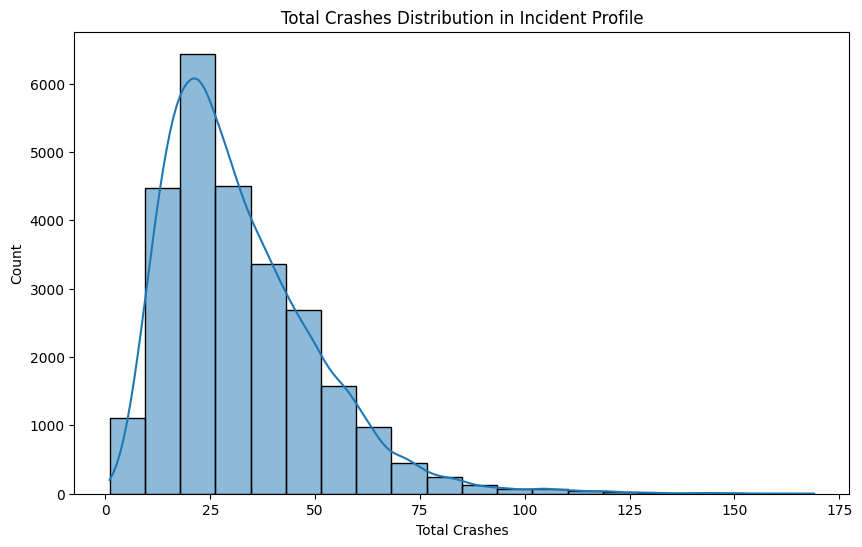

In [33]:
# total crashes distribution
plt.figure(figsize=(10, 6))
sns.histplot(incident_profile["total_crashes"], bins=20, kde=True)
plt.title("Total Crashes Distribution in Incident Profile")
plt.xlabel("Total Crashes")
plt.ylabel("Count")

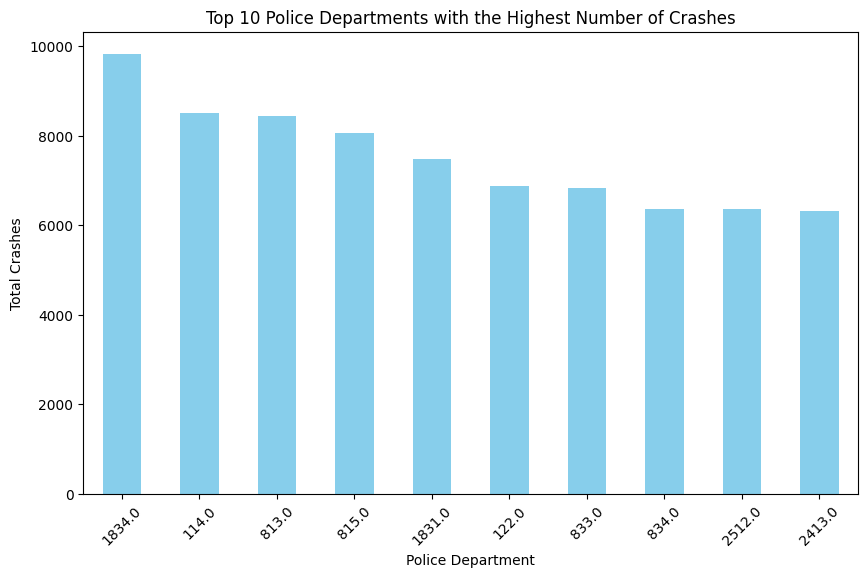

In [34]:
# top 10 police departments with the highest number of crashes
top_police_departments = incident_profile.groupby("BEAT_OF_OCCURRENCE")["total_crashes"].sum().nlargest(10)
plt.figure(figsize=(10, 6))
top_police_departments.plot(kind="bar", color="skyblue")
plt.title("Top 10 Police Departments with the Highest Number of Crashes")
plt.xlabel("Police Department")
plt.ylabel("Total Crashes")
plt.xticks(rotation=45)
plt.show()


C:\Users\chucki\AppData\Local\Temp\ipykernel_13236\1614737875.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=incident_profile, x="BEAT_OF_OCCURRENCE", y="avg_age", palette="coolwarm")


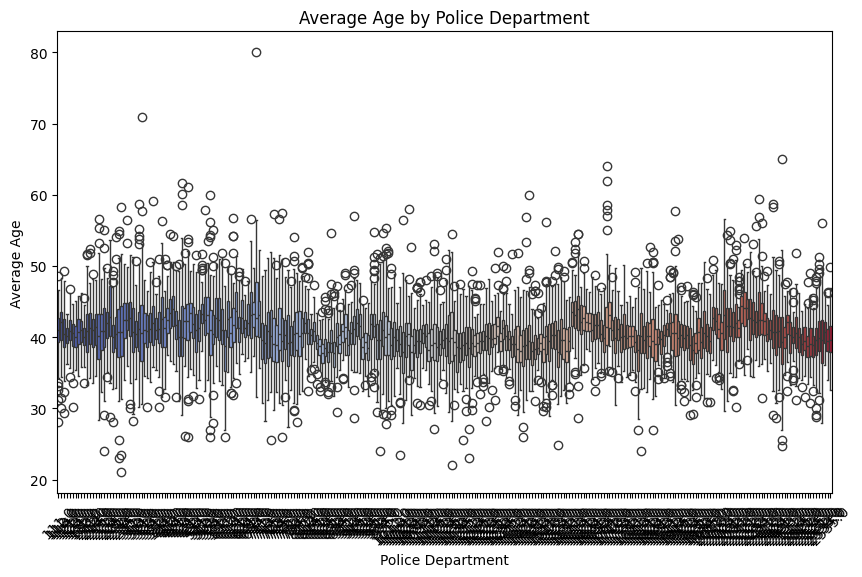

In [35]:
# boxplot for average age by police department
plt.figure(figsize=(10, 6))
sns.boxplot(data=incident_profile, x="BEAT_OF_OCCURRENCE", y="avg_age", palette="coolwarm")
plt.title("Average Age by Police Department")
plt.xlabel("Police Department")
plt.ylabel("Average Age")
plt.xticks(rotation=45)
plt.show()


In [40]:
# isolation tree for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Selecting features for anomaly detection
features = [
    "avg_age"
]

# Splitting the data into training and testing sets
X_train, X_test = train_test_split(incident_profile[features], test_size=0.2, random_state=42)

# Training the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(X_train)

# Predicting anomalies
anomalies = isolation_forest.predict(X_test)
anomalies = pd.Series(anomalies).replace({1: 0, -1: 1})

# Displaying the number of anomalies
anomalies.value_counts()


0    5191
1      46
Name: count, dtype: int64

In [41]:
# Displaying the anomalies
anomalies_df = X_test.copy()
anomalies_df["anomaly"] = anomalies
anomalies_df[anomalies_df["anomaly"] == 1]


,avg_age,anomaly
3739,41.833333,1.0
520,50.333333,1.0
482,40.416667,1.0
2583,37.682540,1.0
2004,39.777778,1.0
121,35.685185,1.0
2698,41.775794,1.0
1349,44.306452,1.0
